In [6]:
import pandas as pd
import requests
from datetime import datetime
import os
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)        # Set display width to avoid line breaks

# Load configuration from JSON file
with open('config.json') as config_file:
    config = json.load(config_file)
    GOOGLE_MAPS_API_KEY = config['GOOGLE_MAPS_API_KEY']
    token = config['fuel_token']

# Set the headers for the request
headers = {
    "Authorization": f"FPDAPI SubscriberToken={token}",
    "Content-Type": "application/json"
}

# Function to fetch fuel data (as in your original code)
def fetch_fuel_data():
    # Fetch Fuel Types, Brands, Site Details, Site Prices as in your code
    # ...

    # Step 1: Get Fuel Types
    url_fuel_types = "https://fppdirectapi-prod.fuelpricesqld.com.au/Subscriber/GetCountryFuelTypes"
    response_fuel_types = requests.get(url_fuel_types, headers=headers, params={"countryId": "21"})
    df_fuel_types = pd.DataFrame()
    if response_fuel_types.status_code == 200:
        fuel_types_data = response_fuel_types.json()['Fuels']
        df_fuel_types = pd.json_normalize(fuel_types_data)

    # Step 2: Get Brands
    url_brands = "https://fppdirectapi-prod.fuelpricesqld.com.au/Subscriber/GetCountryBrands"
    response_brands = requests.get(url_brands, headers=headers, params={"countryId": "21"})
    df_brands = pd.DataFrame()
    if response_brands.status_code == 200:
        brands_data = response_brands.json()['Brands']
        df_brands = pd.json_normalize(brands_data)

    # Step 3: Get Site Details
    url_site_details = "https://fppdirectapi-prod.fuelpricesqld.com.au/Subscriber/GetFullSiteDetails"
    response_sites = requests.get(url_site_details, headers=headers, params={"countryId": "21", "GeoRegionLevel": "3", "GeoRegionId": "1"})
    df_sites_all = pd.DataFrame()
    if response_sites.status_code == 200:
        sites_data = response_sites.json()['S']  # Assuming the key is 'Sites'
        df_sites_all = pd.json_normalize(sites_data)
        df_sites_all.rename(columns={
            'S': 'Site ID',
            'N': 'Name',
            'A': 'Address',
            'B': 'Brand ID',
            'P': 'Postcode',
            'G1': 'Geographic Region Level 1',
            'G2': 'Geographic Region Level 2',
            'G3': 'Geographic Region Level 3',
            'G4': 'Geographic Region Level 4',
            'G5': 'Geographic Region Level 5',
            'Lat': 'Latitude',
            'Lng': 'Longitude',
            'M': 'Last Modified',
            'GPI': 'Google Place ID'
        }, inplace=True)

    # Step 4: Get Site Prices
    url_site_prices = "https://fppdirectapi-prod.fuelpricesqld.com.au/Price/GetSitesPrices"
    response_prices = requests.get(url_site_prices, headers=headers, params={"countryId": "21", "geoRegionLevel": "3", "geoRegionId": "1"})
    df_fuel_prices = pd.DataFrame()
    if response_prices.status_code == 200:
        fuel_prices_data = response_prices.json()['SitePrices']
        df_fuel_prices = pd.json_normalize(fuel_prices_data)

    # Step 5: Merge DataFrames
    # Merge site details with brands using 'Brand ID'
    merged_df = pd.merge(df_sites_all, df_brands, left_on='Brand ID', right_on='BrandId', how='left')

    # Merge fuel prices with sites using 'Site ID'
    merged_df = pd.merge(merged_df, df_fuel_prices, left_on='Site ID', right_on='SiteId', how='left')

    # Merge fuel types with prices using 'FuelId'
    merged_df = pd.merge(merged_df, df_fuel_types, left_on='FuelId', right_on='FuelId', how='left')

    # Select and rename the desired columns
    final_df = merged_df[[
        'Site ID', 'Address', 'Name_x', 'Postcode', 'Latitude', 
        'Longitude', 'Google Place ID', 'Name_y', 'TransactionDateUtc', 
        'Price', 'Name', 'FuelId'
    ]].rename(columns={
        'Site ID': 'site_id',
        'Address': 'address',
        'Name_x': 'station_name',
        'Postcode': 'postcode',
        'Latitude': 'latitude',
        'Longitude': 'longitude',
        'Google Place ID': 'gp_id',
        'Name_y': 'brand_name',
        'TransactionDateUtc': 'transaction_date_time',
        'Price': 'price',
        'Name': 'fuel_name'
    })


    # Merge data as in your original code
    # final_df = merged_df[...]  # your merged dataframe
    return final_df

# Function to compare and get new/updated data
def get_new_data(new_data, old_data):

    # Ensure postcodes are strings in both DataFrames
    new_data['postcode'] = new_data['postcode'].astype(str)
    old_data['postcode'] = old_data['postcode'].astype(str)

    # Merge new and old data based on site_id and FuelId
    merged = pd.merge(new_data, old_data, how='left', 
                      on=['site_id', 'FuelId'], 
                      suffixes=('_new', '_old'), 
                      indicator=True)
    
    # Find rows where transaction_date_time or price have changed
    diff = merged[
        (merged['_merge'] == 'left_only') |  # New entries
        (merged['transaction_date_time_new'] != merged['transaction_date_time_old']) |  # Date changed
        (merged['price_new'] != merged['price_old'])  # Price changed
    ]
    
    # Keep only the relevant columns (site_id, FuelId, and the changed values)
    diff = diff[['site_id', 'FuelId', 'transaction_date_time_new', 'price_new']].rename(columns={
        'transaction_date_time_new': 'transaction_date_time',
        'price_new': 'price'
    })

    return diff



# File path
#file_path = 'fuel_data_oct.csv'

# Step 1: Fetch new data
new_df = fetch_fuel_data()

## Step 2: Check if the file already exists
#if os.path.exists(file_path):
#    # Load existing data
#    old_df = pd.read_csv(file_path)
#
#    # Step 3: Compare and get the new/updated data
#    diff_df = get_new_data(new_df, old_df)
#    
#    if not diff_df.empty:
#        # Step 4: Append only new/updated data to CSV
#        #diff_df.to_csv(file_path, mode='a', header=False, index=False)
#        #print(f"{len(diff_df)} new/updated rows added.")
#        print(diff_df.head(5))
#    else:
#        print("No updates found.")
#else:
#    # Step 4: Save the new data to CSV if file doesn't exist
#    #new_df.to_csv(file_path, index=False)
#    print(f"{len(new_df)} rows saved to new file.")

# Step 5: Display new data or message
print(new_df.head())

    site_id            address        station_name postcode   latitude   longitude                        gp_id brand_name    transaction_date_time   price            fuel_name  FuelId
0  61290151     61 Burrowes St       Liberty Surat     4417 -27.151627  149.067712  ChIJhbUB8XJVumsR1WCVwJFOMiY    Liberty  2024-06-02T23:56:20.107  1899.0             Unleaded     2.0
1  61290151     61 Burrowes St       Liberty Surat     4417 -27.151627  149.067712  ChIJhbUB8XJVumsR1WCVwJFOMiY    Liberty   2024-08-23T23:49:59.33  1899.0               Diesel     3.0
2  61290151     61 Burrowes St       Liberty Surat     4417 -27.151627  149.067712  ChIJhbUB8XJVumsR1WCVwJFOMiY    Liberty  2024-06-02T23:56:20.107  2099.0  Premium Unleaded 98     8.0
3  61291313  126 Barwon Street  Lowes Mungindi Opt     4497 -28.973667  148.983999  ChIJWyNloETOpWsR2iAu7eiMx30         BP   2024-10-01T22:14:33.93  1830.0             Unleaded     2.0
4  61291313  126 Barwon Street  Lowes Mungindi Opt     4497 -28.973667  148

Skewness of Unleaded fuel prices: 3.550716586490613
Skewness of Diesel fuel prices: 3.9825953177110405
Skewness of Premium Unleaded 98 prices: 1.4512937249569533


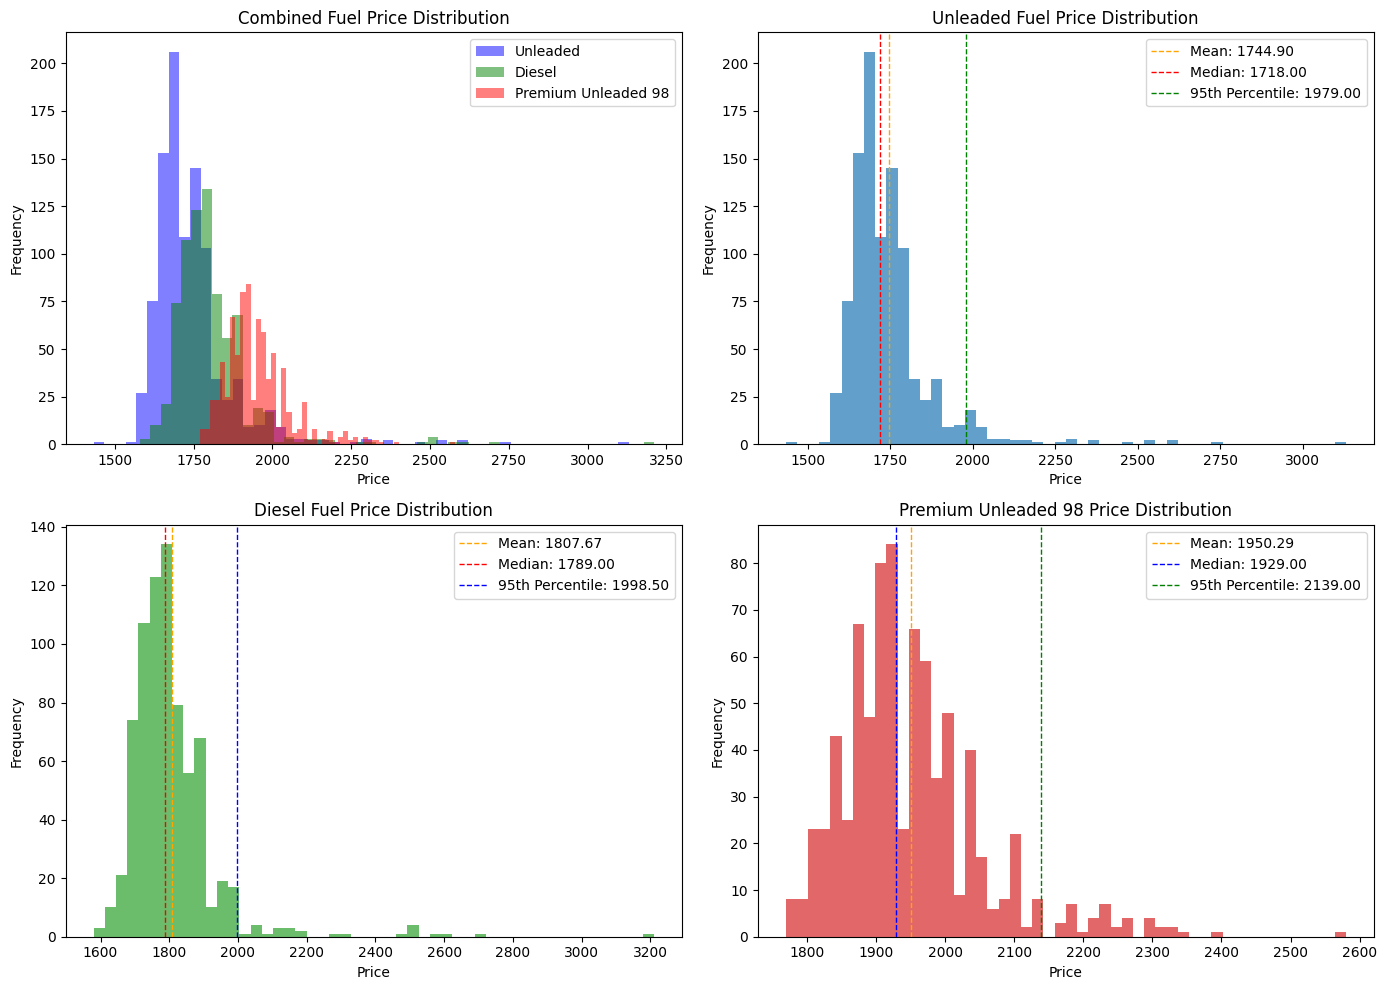

In [35]:
import pandas as pd
from scipy.stats import skew
import matplotlib.pyplot as plt

# Step 1: Convert transaction_date_time to datetime object
new_df['transaction_date_time'] = pd.to_datetime(new_df['transaction_date_time'], errors='coerce')

# Step 2: Define a cutoff date (for example, only keep data from 2023 onwards)
cutoff_date = pd.to_datetime('2024-09-01')

# Step 3: Filter out old data (only keep data after the cutoff date)
df_filtered = new_df[new_df['transaction_date_time'] >= cutoff_date]

# Step 4: Remove outliers (9999 indicates "out of stock") and prices below 1000 (abnormal values)
df_cleaned = df_filtered[(df_filtered['price'] != 9999) & (df_filtered['price'] >= 1000)]

# Step 5: Filter data for Unleaded fuel
unleaded_df = df_cleaned[df_cleaned['fuel_name'] == 'Unleaded']
diesel_df = df_cleaned[df_cleaned['fuel_name'] == 'Diesel']
premium_unleaded_df = df_cleaned[df_cleaned['fuel_name'] == 'Premium Unleaded 98']

# Step 6: Calculate skewness of Unleaded prices
unleaded_prices = unleaded_df['price']
diesel_prices = diesel_df['price']
premium_unleaded_prices = premium_unleaded_df['price']

unleaded_skewness = skew(unleaded_prices)
diesel_skewness = skew(diesel_prices)
premium_unleaded_skewness = skew(premium_unleaded_prices)

print(f'Skewness of Unleaded fuel prices: {unleaded_skewness}')
print(f'Skewness of Diesel fuel prices: {diesel_skewness}')
print(f'Skewness of Premium Unleaded 98 prices: {premium_unleaded_skewness}')

# Step 7: Calculate mean, median, and 95th percentile for each fuel type
unleaded_mean = unleaded_prices.mean()
unleaded_median = unleaded_prices.median()
unleaded_95th = unleaded_prices.quantile(0.95)

diesel_mean = diesel_prices.mean()
diesel_median = diesel_prices.median()
diesel_95th = diesel_prices.quantile(0.95)

premium_unleaded_mean = premium_unleaded_prices.mean()
premium_unleaded_median = premium_unleaded_prices.median()
premium_unleaded_95th = premium_unleaded_prices.quantile(0.95)

# Step 8: Create subplots for each fuel type and combined
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Combined histogram for all three fuel types
axs[0, 0].hist(unleaded_prices, bins=50, alpha=0.5, label='Unleaded', color='blue')
axs[0, 0].hist(diesel_prices, bins=50, alpha=0.5, label='Diesel', color='green')
axs[0, 0].hist(premium_unleaded_prices, bins=50, alpha=0.5, label='Premium Unleaded 98', color='red')
axs[0, 0].set_title('Combined Fuel Price Distribution')
axs[0, 0].set_xlabel('Price')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend(loc='upper right')

# Individual histogram for Unleaded with mean, median, and 95th percentile markers
axs[0, 1].hist(unleaded_prices, bins=50, color='#1f77b4', alpha=0.7)
axs[0, 1].axvline(unleaded_mean, color='orange', linestyle='dashed', linewidth=1, label=f'Mean: {unleaded_mean:.2f}')
axs[0, 1].axvline(unleaded_median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {unleaded_median:.2f}')
axs[0, 1].axvline(unleaded_95th, color='green', linestyle='dashed', linewidth=1, label=f'95th Percentile: {unleaded_95th:.2f}')
axs[0, 1].set_title('Unleaded Fuel Price Distribution')
axs[0, 1].set_xlabel('Price')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# Individual histogram for Diesel with mean, median, and 95th percentile markers
axs[1, 0].hist(diesel_prices, bins=50, color='#2ca02c', alpha=0.7)
axs[1, 0].axvline(diesel_mean, color='orange', linestyle='dashed', linewidth=1, label=f'Mean: {diesel_mean:.2f}')
axs[1, 0].axvline(diesel_median, color='red', linestyle='dashed', linewidth=1, label=f'Median: {diesel_median:.2f}')
axs[1, 0].axvline(diesel_95th, color='blue', linestyle='dashed', linewidth=1, label=f'95th Percentile: {diesel_95th:.2f}')
axs[1, 0].set_title('Diesel Fuel Price Distribution')
axs[1, 0].set_xlabel('Price')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend()

# Individual histogram for Premium Unleaded 98 with mean, median, and 95th percentile markers
axs[1, 1].hist(premium_unleaded_prices, bins=50, color='#d62728', alpha=0.7)
axs[1, 1].axvline(premium_unleaded_mean, color='orange', linestyle='dashed', linewidth=1, label=f'Mean: {premium_unleaded_mean:.2f}')
axs[1, 1].axvline(premium_unleaded_median, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {premium_unleaded_median:.2f}')
axs[1, 1].axvline(premium_unleaded_95th, color='green', linestyle='dashed', linewidth=1, label=f'95th Percentile: {premium_unleaded_95th:.2f}')
axs[1, 1].set_title('Premium Unleaded 98 Price Distribution')
axs[1, 1].set_xlabel('Price')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [36]:

# Step 5: Calculate the 95th percentile of Unleaded prices
percentile_95 = unleaded_df['price'].quantile(0.95)

# Step 6: Filter for prices higher than the 95th percentile
high_price_sites = unleaded_df[unleaded_df['price'] > percentile_95]

# Step 7: Print site addresses of high-priced sites
print("Sites with prices higher than the 95th percentile:")
print(high_price_sites[['station_name', 'address', 'price']])

Sites with prices higher than the 95th percentile:
                                 station_name                                            address   price
145                                  BP Tugun                                 468 Golden Four Dr  1999.0
1944                         Winton Roadhouse                                    35 Chirnside St  2059.0
2143                    Shell Tambo Roadhouse                                        1 Arthur St  2039.0
2343                          Ampol Longreach                             Duck St & Sandpiper St  2099.0
2469                              IOR Emerald                                      74 Roberts St  2049.0
2633  Shell Reddy Express Mount Isa Truckport                             221-239 Barkly Highway  2039.0
2960                  Point Lookout Roadhouse                                     126 Dickson Wy  2019.0
2998                           BP Blackall SS                                  8 Shamrock Street  2089.0
3004

In [37]:
# Filter out outliers based on the calculated thresholds
new_df_filtered = df_cleaned

# 1. Get median prices per fuel type
median_prices = new_df_filtered.groupby('fuel_name')['price'].median().reset_index()
median_prices.rename(columns={'price': 'median_price'}, inplace=True)

print(median_prices)

             fuel_name  median_price
0               Diesel        1789.0
1                  LPG        1119.0
2                 OPAL        2089.0
3       Premium Diesel        1799.0
4  Premium Unleaded 95        1859.0
5  Premium Unleaded 98        1929.0
6             Unleaded        1718.0
7                  e10        1679.0
8                  e85        2199.0


In [38]:
import folium

# 2. Get price difference: site price - median price
new_df_filtered = new_df_filtered.merge(median_prices, on='fuel_name', how='left')
new_df_filtered['price_difference'] = new_df_filtered['price'] - new_df_filtered['median_price']

## Handle NaN values in price_difference
#new_df_filtered['price_difference'].fillna(0, inplace=True)  # Fill NaNs with 0 or use dropna() if you prefer to remove them

print(new_df_filtered)

In [40]:
# Create separate maps for each fuel type
fuel_types = new_df_filtered['fuel_name'].unique()

for fuel in fuel_types:
    # Filter the data for the specific fuel type
    fuel_df = new_df_filtered[new_df_filtered['fuel_name'] == fuel]
    
    # Create a map for the current fuel type
    # Brisbane and Gold Coast
    price_map = folium.Map(location=[-27.74325, 153.21255], zoom_start=10, tiles='CartoDB positron')
    # Brisbane City
    #price_map = folium.Map(location=[-27.4698, 153.0251], zoom_start=12)
    # Queensland
    #price_map = folium.Map(location=[-22, 151.0], zoom_start=6)
    
    # Calculate the min and max price differences for color mapping
    min_diff = fuel_df['price_difference'].min()
    max_diff = fuel_df['price_difference'].max()

    # Add markers for each site with a color gradient based on price difference
    for _, row in fuel_df.iterrows():
        # Normalize the price difference to a scale of 0-1
        normalized_diff = (row['price_difference'] - min_diff) / (max_diff - min_diff) if (max_diff - min_diff) != 0 else 0
        
        # Create a color based on the normalized difference (Green to Red)
        g = int(255 * (1 - normalized_diff))  # Green value decreases with price
        r = int(255 * normalized_diff)  # Red value increases with price
        color = f'#{r:02x}{g:02x}00'  # Constructing hex color code

        folium.CircleMarker(
            location=(row['latitude'], row['longitude']),
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=folium.Popup(f"{row['station_name']}<br>Price: {row['price']}<br>Median: {row['median_price']}<br>Difference: {row['price_difference']}", parse_html=True)
        ).add_to(price_map)

    # Adding a legend to the map for fuel type and color spectrum
    legend_html = f"""
    <div style="position: fixed; 
         bottom: 50px; left: 50px; width: 220px; height: 140px; 
         border:2px solid grey; z-index:9999; font-size:14px;
         background-color: white;">
         <b>Price Difference for {fuel}</b><br>
         <div style="background: linear-gradient(to right, lightgreen, darkgreen, red); width: 200px; height: 20px;"></div>
         <br>
         <i style="background:lightgreen; width: 12px; height: 12px; float:left; margin-right:8px;"></i> Below Median<br>
         <i style="background:darkgreen; width: 12px; height: 12px; float:left; margin-right:8px;"></i> At Median<br>
         <i style="background:red; width: 12px; height: 12px; float:left; margin-right:8px;"></i> Above Median<br>
    </div>
    """

    price_map.get_root().html.add_child(folium.Element(legend_html))

    # Save each map as an HTML file
    display(price_map)